# Project 4: Pretrained Transformer BoolQ

The documentation is split into small chunks following the suggestion in class and from feedback for previous projects.

# Introduction

Classification of BoolQ with a pretrained transformer encoder.

The chosen pretrained transformer encoder is `DEBERTA-v3`. An improved version to the original `BERT` and other successor versions.

Preprocessing of the dataset is left to the implemented `DEBERTA-v2` tokenizer, which is compative with the v3 model.

A customized classification head is added to the pre trained model for the classification task. It consists of 2 linear layers with a relu in between.
The loss function is BCE with logit loss, meaning it takes logits as input before processing with a sigmoid layer.

Experiments were made with a large range of learning rates from potentially 1 to 1-e10. But because of long training times only 7 runs were completed

The best performing model was made with a learning rate of: 0.12

With following performances on the test dataset:
- Accuracy: 0.6218
- Loss: 0.6809

This is same as the ratio of the label inbalance. The model managed to only predict true labels. The reason why that happend is unclear.

W&B Link: https://wandb.ai/yelin-zhang-hslu/nlp-project-4?nw=cx31ikbpeen

# Setup
Preliminary steps for setting getting the project running.

## Tools used
- GPUHub JupyterLab
- No AI tools used, as they do not help with reading API documentation and GitHub issues
- Previous projects documentation

In [ ]:
%pip install lightning==2.4.0 torch==2.3.1 torchmetrics==1.6.0 huggingface_hub==0.26.2 transformers[torch]==4.46.2 sentencepiece==0.2.0 datasets==3.0.1 wandb==0.18.7 numpy==1.26.4 scikit-learn==1.5.2 ruff==0.7.4

  Using cached lightning-2.4.0-py3-none-any.whl.metadata (38 kB)
  Using cached torchmetrics-1.6.0-py3-none-any.whl.metadata (20 kB)
  Using cached huggingface_hub-0.26.2-py3-none-any.whl.metadata (13 kB)
  Using cached transformers-4.46.2-py3-none-any.whl.metadata (44 kB)
  Using cached sentencepiece-0.2.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (7.7 kB)
  Using cached datasets-3.0.1-py3-none-any.whl.metadata (20 kB)
  Using cached wandb-0.18.7-py3-none-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.7 kB)
  Using cached scikit_learn-1.5.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
  Using cached ruff-0.7.4-py3-none-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (25 kB)
  Using cached lightning_utilities-0.11.9-py3-none-any.whl.metadata (5.2 kB)
  Using cached pytorch_lightning-2.4.0-py3-none-any.whl.metadata (21 kB)
  Using cached regex-2024.11.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl

## Dependencies
The notebook was created with:
Python 3.11.9

Install all necessary dependencies
- Pytorch: `torch lightning torchmetrics`
- Hugging Face: `huggingface_hub transformers datasets sentencepiece`
- Weights & Biases: `wandb`
- numpy: `numpy`
- scikit-learn: `scikit-learn`
- Lint and Formatting: `ruff`

Versions of dependencies are pinned for reproducibility.

## Notebook setup
Import all necessary libraries.

In [1]:
import os
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
)
import torch
import numpy as np
from datasets import Value
from datasets import load_dataset
from lightning.pytorch.loggers import WandbLogger
import wandb
import torchmetrics
import sklearn
from pathlib import Path
import lightning as L

Log into Hugging Face and Weights & Biases.

In [2]:
WANDB_PROJECT = "nlp-project-4"
os.environ["WANDB_PROJECT"] = WANDB_PROJECT
os.environ["WANDB_NOTEBOOK_NAME"] = "./project4-stage2.ipynb"
wandb.login()

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find ./project4-stage2.ipynb.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: yelin-zhang (yelin-zhang-hslu). Use `wandb login --relogin` to force relogin


True

Define constants which are used later

In [3]:
MODEL = "microsoft/deberta-v3-small"
BATCH_SIZE = 8

# Preprocessing

Predefined requirements:
- Download the BoolQ dataset with `datasets` and split it in the predefined way.
- Train / Validation / Test split

Used features:
- `question` and `passage` as input to the model
- `answer` as label

Input format:
- concatenated `question` and `passage` strings
- with a special seperator token from the model vocabulary in the middle to differentiate between them
- question before passage because to be able to answer the question it first hast to be known

Label format:
- convert `answer` boolean to 1 or 0
- Model output is probability of 1

Batch size: ~~64 for faster training than with individual samples~~ 8 as more did not fit into memory

A lot of preprocessing steps are not needed, because the predefined tokenizer for the model does most of the work. The input format is the raw text without any changes.
The tokenizer does not do any stemming, stopword removal, lower casing, format cleaning. For unknown words a special token `[UNK]` is used.

## Correctness tests
- Check processed passages and questions if they still make sense
- Check if `[SEP]` has been tokenized correctly

Download and split dataset in predefined way

In [4]:
train_raw = load_dataset("google/boolq", split="train[:-1000]")
valid_raw = load_dataset("google/boolq", split="train[-1000:]")
test_raw = load_dataset("google/boolq", split="validation")

print(len(train_raw), len(valid_raw), len(test_raw))

8427 1000 3270


Convert answer boolean to 1 or 0, because the model output is a probability of 1.

In [5]:
train_casted = train_raw.cast_column("answer", Value("float32"))
valid_casted = valid_raw.cast_column("answer", Value("float32"))
test_casted = test_raw.cast_column("answer", Value("float32"))

- Concat `question` and `passage` into `query`
    - Add special seperator token `[SEP]` between them to distinguish both texts from another
- Tokenize sentence with `DeBERTAV2Tokenizer`
    - It handles the tokenization of the text with `SentencePiece` and the conversion to word vectors as well.
    - `SentencePiece` is a subword tokenizer, which learns how to split the text into subwords based on the pretrain dataset
    - Padding to the maximum input length of each batch is done by the `DataCollatorWithPadding` later
    - Truncation should not be needed, as the maximum input length is quite large (over the usual 512)

In [6]:
tokenizer = AutoTokenizer.from_pretrained(MODEL, use_fast=False)


def preprocess_dataset(row):
    query = row["question"] + "[SEP]" + row["passage"]
    tokenized = tokenizer(query)
    tokenized["labels"] = row["answer"]
    return tokenized


train_concatenated = train_casted.map(preprocess_dataset)
valid_concatenated = valid_casted.map(preprocess_dataset)
test_concatenated = test_casted.map(preprocess_dataset)

Check if the text has been tokenized correctly

In [8]:
tokenizer.decode(train_concatenated[0]["input_ids"])

'[CLS] do iran and afghanistan speak the same language[SEP] Persian (/ˈpɜːrʒən, -ʃən/), also known by its endonym Farsi (فارسی fārsi (fɒːɾˈsiː) ( listen)), is one of the Western Iranian languages within the Indo-Iranian branch of the Indo-European language family. It is primarily spoken in Iran, Afghanistan (officially known as Dari since 1958), and Tajikistan (officially known as Tajiki since the Soviet era), and some other regions which historically were Persianate societies and considered part of Greater Iran. It is written in the Persian alphabet, a modified variant of the Arabic script, which itself evolved from the Aramaic alphabet.[SEP]'

Remove unnecssary `question` and `passage` columns, as they are represented in `query`

In [7]:
train = train_concatenated.remove_columns(["question", "passage"])
valid = valid_concatenated.remove_columns(["question", "passage"])
test = test_concatenated.remove_columns(["question", "passage"])

# Model
Predefined requirements:
- pretrained Transformer encoder (from Hugging Face; it must not be finetuned on the BoolQ dataset yet)
- Classifier
    - 2 Layers
    - ReLu

## Network Architecture
- Transformer encoder
    - ~~`DeBERTa-v3-large`~~`DeBERTa-v3-small`
    - Input Dimension: Batch size x 128100
    - Output Dimension: Batch size x 768
    - It was chosen as the latest version of the `DeBERTa` series, which have improvement over the original `BERT` model.
        - With improvements in attention and pre training over `BERT` and `RoBRTa`.
        - ~~the `large` variant is used because I assume it will fit into memory and performs better than the base variant~~
        - the `small` variant is used because it is the version which fits into memory
        - The `v2` tokenizer is compatible with the `v3` model
- Classifier
    - `nn.Linear`
        - Input Dimension: 768 (Pooled output of `DeBERTa`)
        - Output Dimension: 256
        - Activation: `torch.nn.ReLu`
        - Output shape is smaller than input, to promote the model to learn more abstract features for the classification
    - `nn.Dropout`
        - Dropout rate: 0.1
        - Dropout is used to prevent overfitting, which happens easily with such a small dataset
    - `nn.Linear`
        - Input Dimension: 256
        - Output Dimension: 1
            - Output is probability of class (1 = 100% true, 0 = 0% true)
        - Final Activation: `torch.nn.Sigmoid`

- Normalization: Done in the `DeBERTa` model with their Masked Layer Normalization
- Regularization: Optimizer `AdamW` applies L2 regularization to loss, no regularization layer is in `DeBERTa`

### Loss function
Default by transformers library: Binary Cross-Entropy with logit loss:
- Not changed because it is the best choice for binary classification problems
- and with logits can be better than only Binary cross entropy because it is supposedly more numerically stable

### Optimizer
Default by transformers library: `AdamW`
- Not changed because it performs well and the original `DeBERTa` was also trained with a version of `AdamW`

## Correctness test
Test run of training, validation, test and prediction with 1 input
Check transformer encoder output shapes

## Implementation
The pretrained transformer had to be wrapped in a PyTorch Lightning module because only using the `transformers` library is too restrictive.
The flexibility gained by using PyTorch Lightning is worth the effort.

In [8]:
class Classifier(L.LightningModule):
    def __init__(self, lr=1e3):
        super().__init__()
        self.lr = lr

        transformer = AutoModelForSequenceClassification.from_pretrained(
            MODEL, problem_type="multi_label_classification", num_labels=1
        )
        transformer.classifier = torch.nn.Sequential(
            torch.nn.Linear(768, 256),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(256, 1),
            torch.nn.Flatten(0, 1),
        )

        self.transformer = transformer

    def forward(self, ids, mask, token_type_ids):
        output = self.transformer(
            ids, attention_mask=mask, token_type_ids=token_type_ids, return_dict=False
        )
        return output

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr)
        return optimizer

Define the batch padding function. Using the DeBERTA-v2 tokenzier with its defaults for the padding token.

In [9]:
def batch_collate(batch):
    padded = tokenizer.pad(batch, return_tensors="pt")
    return (
        padded["input_ids"],
        padded["attention_mask"],
        padded["token_type_ids"],
        padded["labels"],
    )

Correctness test of the model definition, by running the model with one batch.

In [12]:
Classifier(batch_collate(train[0:1]))

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Classifier(
  (transformer): DebertaV2ForSequenceClassification(
    (deberta): DebertaV2Model(
      (embeddings): DebertaV2Embeddings(
        (word_embeddings): Embedding(128100, 768, padding_idx=0)
        (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
        (dropout): StableDropout()
      )
      (encoder): DebertaV2Encoder(
        (layer): ModuleList(
          (0-5): 6 x DebertaV2Layer(
            (attention): DebertaV2Attention(
              (self): DisentangledSelfAttention(
                (query_proj): Linear(in_features=768, out_features=768, bias=True)
                (key_proj): Linear(in_features=768, out_features=768, bias=True)
                (value_proj): Linear(in_features=768, out_features=768, bias=True)
                (pos_dropout): StableDropout()
                (dropout): StableDropout()
              )
              (output): DebertaV2SelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
         

### Checkpoints
<s>
Save checkpoints at end of training with `transformers.integrations.WandbCallback` configuration and further configuration later in `TrainingArguments`.
</s>

Best model based on smallest validation loss:
- Uses loss because it is the most important metric for the model
- Save few checkpoints (top 2) to not bloat the storage, because previous project managed to fill wandb storage with too many checkpoints

In [13]:
checkpoint = L.pytorch.callbacks.ModelCheckpoint(
    save_top_k=3, monitor="val_loss", mode="min"
)

## Experiments
Various Learning rates (1 - 1e-10) in a uniform distribution
- Extensive sweep to check which learning rate is optimal
- No learning rate scheduler is needed as AdamW handles adjusting learning rates dynamically on its own with the passed learning rate being the maximum

No other experiments are done, because there are not many other parameters which can be changed, as we are using a pre trained model. Additionally finding the optimal learning rate is the most important part of training the model.
- The classifier hidden sizes are not changed as they are intended to be decreasing. For the model to pre compress the information before the binary classifcation.
- No Weight decay because it might affect the pre trained model negativly
- Learning rate warm up is not done, because max epochs are relativly low  


### Early stop
Early stopping is done by wandb sweeps.
- Compare to previous epochs validation loss
- wandb sweeps use the Hyperband algorithm
- Max epochs 50
- Check every 10 epochs

In [14]:
experiments = {
    "method": "bayes",
    "metric": {"goal": "minimize", "name": "val_loss"},
    "parameters": {
        "lr": {"max": 1.0, "min": 1e-10},
    },
    "early_terminate": {"type": "hyperband", "max_iter": 20, "s": 5, "eta": 3},
}

# Training
<s>
Training is done with the `Trainer` class from the `transformers` library.
Configure training and evaluation with `TrainingArguments`.
- set `seed` for reproducibility
- `logging_strategy = 'epoch'` to log metrics after each epoch
- `eval_strategy = 'epoch'` to evaluate after each epoch
- `save_strategy = 'steps'` to save after ever 500 steps
- `save_total_limit = 3` to save only the last 3 checkpoints
- `label_names = ['answer']` to set the label name to the key we use
- `report_to = 'wandb'` to log metrics to wandb
- `run_name` to set the name of the run to an informative name
- `dataloader_num_workers = 4` to speed up data loading
- `per_device_train_batch_size = 64` to set the desired batch size for training
- `per_device_eval_batch_size = 64` to set the desired batch size for evaluation
- `num_train_epochs = 50` to set the desired max epochs

Accuracy has to be implemented seperatly for training and evaluation, because `Trainer` from `transformers` only logs loss per default.
- Create a `TrainerCallback` for training accuracy
- Define `compute_metrics` method for validation accuracy
</s>

Metrics for training and validation:
- Accuracy, because we are interested in both correct true and false predictions
- Loss, to see how confident the model is in its predictions
- Metrics are logged every epoch. Because logging per step is very noisy and does not have a benefit.

Loss is the main metric for all decisions, as it is the most important metric for the model. Accuracy should follow loss in a correct model. Therefore, it is not necessary to optimize for accuracy.

As discussed in class no other metrics are needed for training and validation. As accuracy and loss are sufficient to evaluate which model is the best.


## Implementation

I planned on using the `transformers` library to train the model but after an inital run it turned out to be problematic.
The classification head has to be customized to fit the requirements. But after training it, it cannot be loaded from a checkpoint again. Because while loading the model it expects the default classification head weights. There seems to be no way to load the customized classification head.

Therefore I reverted back to the PyTorch Lightning training implementation. With the lightning style config for metrics, checkpoints etc.

Define Lighning training hook and helper function to calculate loss and metrics

In [10]:
def training_step(self, batch, batch_idx):
    _, _, loss, acc = self._get_pred_metrics(batch)
    self.log_dict(
        {
            "train_loss": loss,
            "train_accuracy": acc,
        },
        batch_size=BATCH_SIZE,
    )
    return loss


def _get_pred_metrics(self, batch):
    ids = batch[0]
    mask = batch[1]
    token_type_ids = batch[2]
    labels = batch[3]
    preds = self(ids, mask, token_type_ids)[0]

    loss = torch.nn.functional.binary_cross_entropy_with_logits(preds, labels)
    preds = torch.sigmoid(preds)
    acc = torchmetrics.functional.classification.accuracy(preds, labels, task="binary")
    return preds, labels, loss, acc


Classifier._get_pred_metrics = _get_pred_metrics
Classifier.training_step = training_step

Define Lightning validation hook

In [16]:
def validation_step(self, batch, batch_idx):
    _, _, loss, acc = self._get_pred_metrics(batch)
    self.log_dict(
        {
            "val_loss": loss,
            "val_accuracy": acc,
        },
        batch_size=BATCH_SIZE,
    )
    return loss


Classifier.validation_step = validation_step

Test training and validation functions

In [17]:
dev_trainer = L.Trainer(fast_dev_run=True, limit_test_batches=1)
dev_model = Classifier()
dev_trainer.fit(
    model=dev_model,
    train_dataloaders=torch.utils.data.DataLoader(
        train, batch_size=BATCH_SIZE, collate_fn=batch_collate
    ),
    val_dataloaders=torch.utils.data.DataLoader(
        train, batch_size=BATCH_SIZE, collate_fn=batch_collate
    ),
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1` reached.


Define wandb sweep function

In [18]:
train_loader = torch.utils.data.DataLoader(
    train,
    batch_size=BATCH_SIZE,
    num_workers=2,
    pin_memory=True,
    collate_fn=batch_collate,
)
valid_loader = torch.utils.data.DataLoader(
    valid,
    batch_size=BATCH_SIZE,
    num_workers=2,
    pin_memory=True,
    collate_fn=batch_collate,
)

In [19]:
def sweep():
    with wandb.init(project=WANDB_PROJECT) as run:
        name = f"debertav3-small/lr:{wandb.config['lr']}"
        run.name = name

        logger = WandbLogger(project=WANDB_PROJECT, log_model="all", name=name)
        classifier = Classifier(**wandb.config)
        trainer = L.Trainer(
            max_epochs=20,
            logger=logger,
            accelerator="gpu",
            devices=1,
            callbacks=[checkpoint],
        )
        try:
            trainer.fit(
                model=classifier,
                train_dataloaders=train_loader,
                val_dataloaders=valid_loader,
            )
        except Exception as e:
            print(e)
        finally:
            wandb.finish()
        wandb.finish()


sweep_id = wandb.sweep(sweep=experiments, project=WANDB_PROJECT)

wandb.agent(sweep_id, function=sweep, project=WANDB_PROJECT)
wandb.teardown()

'\nsweep_id = wandb.sweep(sweep=experiments, project=WANDB_PROJECT)\n\nwandb.agent(sweep_id, function=sweep, project=WANDB_PROJECT)\nwandb.teardown()\n'

- Use `wandb.sweep` for hyperparameter tuning.
- Bayesian search will be used, because there is only one hyperparameter choices and it is continous

After all experiments have run select best runs based on the smallest loss as the final model to be evaluated.

In [12]:
# check wandb for sweep id
SWEEP_ID = "rj306mp8"

api = wandb.Api()
sweep = api.sweep(f"yelin-zhang-hslu/{WANDB_PROJECT}/{SWEEP_ID}")
runs = sorted(
    sweep.runs,
    key=lambda run: run.summary.get("val_loss", 99),
    reverse=False,
)
val_loss = runs[0].summary.get("val_loss", 99)
print(f"Best run {runs[0].name} with {val_loss} validation loss")

Best run debertav3-small/lr:0.12782677083914937 with 0.6839770674705505 validation loss


# Evaluation
Metrics:
- Accuracy
    - to be able to compare the model to the previous projects
    - As well as to check how it compares to the dataset imbalance
    - `torchmetrics.functional.classification.accuracy(preds, target, task='binary')`
- Confusion matrix
    - To be able to see where the model tends to make mistakes.
    - `torchmetrics.functional.confusion_matrix(preds, target, num_classes=2)`
    - As discussed in class: use scikit-learn instead of wandb, as it is easier to interpret
- Total false predictions
    - To see how many false predictions the model made

The averaging of the metrics is the default of `micro` which means the metrics are caculated without weighting of the classes.

<s>
Evaluation will also be done with the `Trainer` class, just using the `evaluate` method and the test dataset.
</s>

## Implementation
The evaluation is also done with Lighning hooks instead of the `transfomer` `Trainer` class, because the implementaiton of the model and training changed


## Result
The model only predicts the majority class. Therefore reaching the majority class ratio as accuracy for all 3 datasets. It does not predict the `false` class even once.

The validation loss curve (as seen in wandb) has plateaued very early on.


Define lightnng test and prediction hooks

In [13]:
def test_step(self, batch, batch_idx):
    (
        preds,
        answers,
        loss,
        acc,
    ) = self._get_pred_metrics(batch)
    stats = torchmetrics.StatScores(task="binary").to(self.device)
    scores = stats(preds, answers)
    false_preds = scores[2] + scores[3]
    total_false = false_preds / len(preds)
    self.log_dict(
        {"test_loss": loss, "test_accuracy": acc, "test_false_pred_ratio": total_false},
        batch_size=BATCH_SIZE,
    )
    return loss


def predict_step(self, batch, batch_idx, dataloader_idx=0):
    ids = batch[0]
    mask = batch[1]
    token_type_ids = batch[2]
    return self(ids, mask, token_type_ids)[0]


Classifier.test_step = test_step
Classifier.predict_step = predict_step

Check if the implementation for test and predict are correct by running it once and checking the output

In [22]:
dev_trainer.test(
    model=dev_model,
    dataloaders=torch.utils.data.DataLoader(
        train, batch_size=BATCH_SIZE, collate_fn=batch_collate
    ),
)
dev_trainer.predict(
    model=dev_model,
    dataloaders=torch.utils.data.DataLoader(
        train, batch_size=BATCH_SIZE, collate_fn=batch_collate
    ),
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy                 0.5
  test_false_pred_ratio             1.0
        test_loss          9.297155932867789e+16
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

[tensor([-1.8594e+17, -1.8594e+17, -1.8594e+17, -1.8594e+17, -1.8594e+17,
         -1.8594e+17, -1.8594e+17, -1.8594e+17])]

Load the best model from wandb artifact registry.

In [14]:
checkpoint_reference = f"yelin-zhang-hslu/{WANDB_PROJECT}/model-{runs[0].id}:v1"

artifact = api.artifact(checkpoint_reference).download()
wandb.init(project=WANDB_PROJECT, id=runs[0].id, resume="allow")

final_model = Classifier.load_from_checkpoint(Path(artifact) / "model.ckpt")

wandb: Downloading large artifact model-sjf22q4s:v1, 1626.25MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:3.0


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Define confusion matrix

In [15]:
def create_confusion_matrix(trainer, classifier, dataset):
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        num_workers=2,
        pin_memory=True,
        collate_fn=batch_collate,
    )
    pred_batches = trainer.predict(classifier, dataloaders=dataloader)
    preds = np.array([])
    for batch in pred_batches:
        preds = np.concatenate((preds, batch.squeeze().numpy()))
    matrix = sklearn.metrics.ConfusionMatrixDisplay.from_predictions(
        y_true=dataset["answer"],
        y_pred=np.round(preds),
    )
    return matrix

Run evaluation of final model with test and validation dataset.

In [16]:
wandb.init(project=WANDB_PROJECT, id=runs[0].id, resume="allow")

eval_logger = WandbLogger(project=WANDB_PROJECT, log_model="all")
eval_trainer = L.Trainer(
    logger=eval_logger,
    accelerator="gpu",
    devices=1,
)

epoch,0
train_accuracy,0.25
train_loss,0.62756
trainer/global_step,0
val_accuracy,0.595
val_loss,0.68398


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/opt/conda/lib/python3.11/site-packages/lightning/pytorch/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      val_accuracy          0.5950000286102295
        val_loss            0.6839770674705505
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

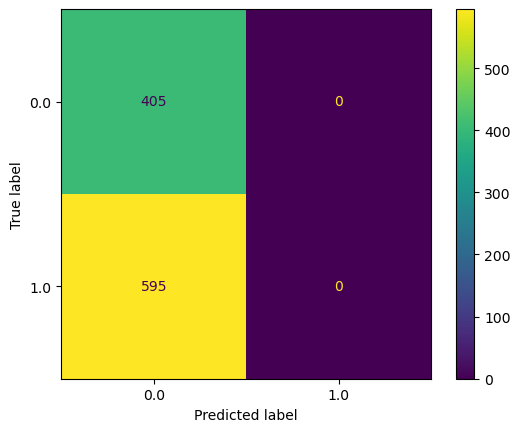

In [26]:
eval_trainer.validate(final_model, dataloaders=valid_loader)
validation_matrix = create_confusion_matrix(eval_trainer, final_model, valid)
wandb.log({"valid_conf_matrix": validation_matrix.im_})
validation_matrix

You are using a CUDA device ('NVIDIA A16') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/opt/conda/lib/python3.11/site-packages/lightning/pytorch/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.6218419075012207
  test_false_pred_ratio             0.0
        test_loss           0.6809313297271729
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

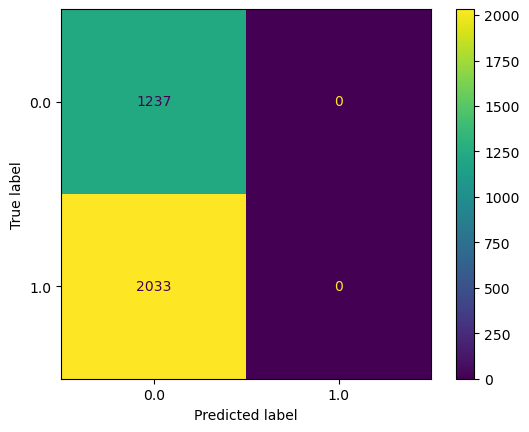

In [17]:
test_loader = torch.utils.data.DataLoader(
    test,
    batch_size=BATCH_SIZE,
    num_workers=2,
    pin_memory=True,
    collate_fn=batch_collate,
)
eval_trainer.test(final_model, dataloaders=test_loader)
test_matrix = create_confusion_matrix(eval_trainer, final_model, test)
wandb.log({"test_conf_matrix": test_matrix.im_})
test_matrix

# Interpretation
Expectation:
70% accuracy with test dataset. The expectation is that by using a good pretrained transformer encoder model (e.g. BERT family) that it has learned the semantics of words and sentences already. Therefore the classification of the questions should be easier.

## Results
The resulting model is a pure majority class classifiers. This is probably due to the limited training runs with high learning rate values. If training would have run longer with smaller learning rates, it might have been able to learn the distribution better.

The interpertation of the validation loss curves of the few runs that managed to complete is that:
- learning rate over ~0.3 are pure minority class classifiers
- learning rate under ~0.3 will probably be pure majority class classifiers
- even smaller learning rates (probably at most ~0.01) would be needed, to get a mix of classifications

In comparison to previous project this one performs about the same, but is special because it is a pure majority class classifier. Which did not happen with the simpler models, as they used reasonable learning rates.

## Learning
- Pre trained models are powerful, but require lots of resources to run.
- Very slow and long traning times to tune large pre trained models.
- Restrict continous learning rate experiments to a smaller range. 
- The `transformer` libary offers simple tools to run models, but is not reasonable to use if the defaults do not work. Being able to customize many aspects is very important after all when creating your own model.